# PROJECT

### The problem

Let us consider the two-dimensional spatial domain  
$$
\Omega = (0,1)^2.
$$  

We want to solve the following **parametrized problem**:  
given  
$$
\mu = (\mu_0, \mu_1) \in \mathcal{P} = [0.1, 1]^2,
$$  
find $u(\mu)$ such that
$$
- \Delta u(\mu) + \frac{\mu_0}{\mu_1} \left( e^{\mu_1 u(\mu)} - 1 \right) = g(x; \mu),
$$  
with **homogeneous Dirichlet boundary conditions** on $\partial\Omega$.

### Part 2

The source term is defined as:  
$$
g(x; \mu) = g_2(x) = 100 \sin(2\pi\mu_0 x_0) \cos(2\pi\mu_0 x_1), \quad \forall x = (x_0, x_1) \in \Omega.
$$


### Variational formulation

Let $\Omega = (0,1)^2$ and $V = H_0^1(\Omega)$.  
Given $\mu = (\mu_0, \mu_1) \in [0.1, 1]^2$,  
find $u(\mu) \in V$ such that
$$
\underbrace{\int_{\Omega} \nabla u(\mu) \cdot \nabla v \, dx}_{f_1}
+ \underbrace{\frac{\mu_0}{\mu_1} \int_{\Omega} e^{\mu_1 u(\mu)} v \, dx}_{f_2}
- \underbrace{\frac{\mu_0}{\mu_1} \int_{\Omega} v \, dx}_{f_3}
- \underbrace{\int_{\Omega} g(x; \mu) v \, dx}_{f_4} = 0,
\quad \forall v \in V.
$$

### Legend

- $f_1$: diffusion term -> collegato alla stiffness  
- $f_2$: nonlinear reaction term  
- $f_3$: constant reaction term  
- $f_4$: source term


### Linearized problem: Newton step
NB: C'E' DIPENDENZA DA MU OVUNQUE

At each iteration $k$, given $u^{(k)} \in V$, find the increment $\delta u^{(k)} \in V$ such that:
$$
J_F(u^{(k)},\delta u^{(k)}) \, \delta u^{(k)} = -F(u^{(k)}),
$$.
In our case:
$$
\left( \int_{\Omega} \nabla \delta u^{(k)} \cdot \nabla v \, dx
+ {\mu_0} \int_{\Omega} e^{\mu_1 u^{(k)}} \delta u^{(k)} v \, dx\right) \delta u^{(k)}
= -F(u^{(k)}; v)
\quad \forall v \in V,
$$
where
$$
F(u^{(k)}; v) =
\int_{\Omega} \nabla u^{(k)} \cdot \nabla v \, dx
+ \frac{\mu_0}{\mu_1} \int_{\Omega} e^{\mu_1 u^{(k)}} v \, dx
- \frac{\mu_0}{\mu_1} \int_{\Omega} v \, dx
- \int_{\Omega} g(x; \mu) v \, dx.
$$

Then update:
$$
u^{(k+1)} = u^{(k)} + \delta u^{(k)}.
$$
### Legend: RICORDA, ORA LA MIA VARIABILE E' DELTA_U_K, NON U_K
- $stiffness_a$: riferito a stiffness (primo a sinistra)
- $reaction_b$ : riferito alla reaction
- A DESTRA STESSI NOMI DI PRIMA( QUANDO ASSEMBLI FAI ATTENZIONE AI SEGNI) 
- $f_1$
- $f_2$
- $f_3$
- $f_4$



In [1]:
import sys
sys.path.append('../../CppToPython')

In [2]:
import numpy as np
import time
import GeDiM4Py as gedim

In [3]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

 ### 1. POD

#### First, find High fidelity
Remember: since a(u,v) is non linear, we use the Newton method to solve it.

##### Define the quantities that we need to assemble the matrices

In [4]:
# attenzione: ricordati poi di premoltiplicare per il parametro, se c'è
def Diffusion_a(numPoints, points): # vettore unitario che moltiplica il primo integrale
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data
# vettore unitario che moltiplica il secondo integrale
def Reaction_b(numPoints, points): 
	values_b = np.ones(numPoints, order='F')
	return values_b.ctypes.data
# vettore con exp(mu_1*u) valutato nei punti di quadratura(?)
def Reaction_non_linear_b(numPoints, points, u, u_x, u_y): 
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
	return values_nl_b.ctypes.data
 # f_1 (è uguale al Lab 12)
def Term_non_linear_der_f_1(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data
# f_2
def Term_non_linear_f_2(numPoints, points, u, u_x, u_y): 
    vecu = gedim.make_nd_array(u, numPoints, np.double)
    values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
    #print("vecu max:", np.max(vecu))
    #print("mu_1 * vecu max:", np.max(mu_1 * vecu))
    return values_nl_b.ctypes.data

# f_4 (parte con la g) DIVERSA DA PRIMA (devo moltiplicare dentro sin e cos per mu_0)
def Term_f_4(numPoints, points): 
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = 100 * np.sin(2*np.pi*mu_0*matPoints[0,:]) * np.cos(2*np.pi*mu_0*matPoints[1,:])
	return values_f.ctypes.data

def Ones_f_2(numPoints, points): # serve per f_2
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def Ones_f_3(numPoints, points): # serve per f_3
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def OnesDerivative_f_1(numPoints, points): # serve per f_1
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data
# serve per il calcolo delle norme (tipo ||du|| = ||du-0||
def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data
# serve per la nroma H1
def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data


##### Define the Mesh size and the order of discretization

In [5]:
meshSize = 0.001
order = 1

##### Create the mesh and plot it

In [6]:
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

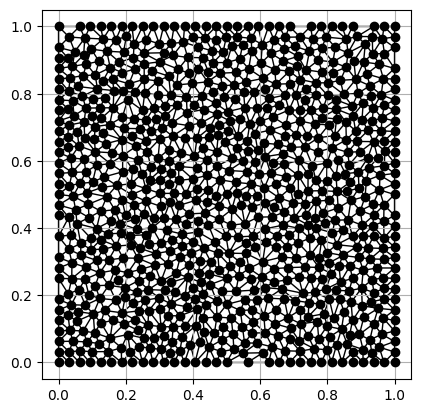

In [7]:
gedim.PlotMesh(mesh)

#### Create Discrete Space FEM and plot the mesh

In [8]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

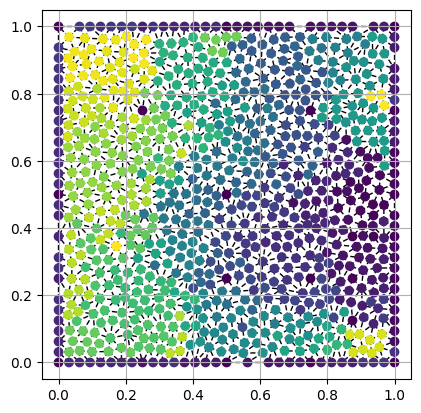

In [9]:
gedim.PlotDofs(mesh, dofs, strongs)

### Newton phase

#### Initial values and Hyperparameters

In [10]:
residual_norm = 1.0  # per farlo entare nel loop
solution_norm = 1.0 #per farlo entarre nel loop
newton_tol = 1.0e-8 #tolleranza relativa
max_iterations = 100 # eventualmente, modifica
num_iteration = 1

In [11]:
# initial guess u
u_k = np.zeros(problemData['NumberDOFs'], order='F') # eventualmente modifica: così potrebbe non convergere
# value on the border (=0) bc homogenous dirichlet
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

In [12]:
np.random.seed(123)  # Imposta il seed per la riproducibilità
snapshots_num = 100 # (M)
training_set = np.random.uniform(low=0.1, high=1, size=(snapshots_num, 2)) # training set

In [13]:
print("{:<8s} {:<6s} {:>14s} {:>10s} {:>10s} {:>15s}".format(
    "DOFs", "h", "Rel. Residual", "Iter", "Max Iter", "mu = (μ₀, μ₁)"
))
#Possono stare fuori tutti i temini che non dipendono da termini non lienari (uk) e quindi detro il while loro, e quelli che non dipendono da mu
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion_a, problemData, lib)
forcingTerm_f_3 = gedim.AssembleForcingTerm(Ones_f_3, problemData, lib)

snapshot_matrix = []


for mu in training_set:

    # devo riaggiornare u_k inizale ogni volta, (ma in realtà ha anche senso dargli la soluzione precednte che è buona per avere una convergenza più rapida)
    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    mu_0 = mu[0]
    mu_1 = mu[1]
    u_normL2 = 1
    u_normH1 = 1
    num_iteration = 1
    residual_norm = 10
    solution_norm = 1.0
    # devo riassmblarlo per ogni mu perche varia con mu stavolta
    forcingTerm_f_4 = gedim.AssembleForcingTerm(Term_f_4, problemData, lib)
    
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction_b, Reaction_non_linear_b, u_k, u_strong, problemData, lib)

        forcingTerm_der_f_1 = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative_f_1, Term_non_linear_der_f_1, u_k, u_strong, problemData, lib)
        forcingTerm_f_2 = gedim.AssembleNonLinearForcingTerm(Ones_f_2, Term_non_linear_f_2, u_k, u_strong, problemData, lib)

        # define right and left hand sides
        rhs = -forcingTerm_der_f_1 - mu_0/mu_1 * forcingTerm_f_2 + mu_0/mu_1 * forcingTerm_f_3 + forcingTerm_f_4
        lhs = stiffness + mu_0 * reaction
        # solve linear system to find du
        du = gedim.LUSolver(lhs, \
                rhs, \
                lib)
        #update u_k
        u_k = u_k + du
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
    
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        solution_norm =  u_normL2
        residual_norm =  du_normL2
        #print(residual_norm)
        """relative L2 e H1 errore non hann senso qui perche riferiti alla soluzione esatta"""
        
        print("{:<8d} {:<8.3f} {:<14.6e} {:<6d} {:<6d}   mu = ({:.3f}, {:.3f})".format(
            problemData['NumberDOFs'],
            problemData['H'],
            residual_norm / u_normL2,
            num_iteration,
            max_iterations,
            mu_0,
            mu_1
        ))

        num_iteration += 1
    snapshot_matrix.append(np.copy(u_k))
    
snapshot_matrix = np.array(snapshot_matrix) 
print(snapshot_matrix.shape)

DOFs     h       Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
713      0.064    1.000000e+00   1      100      mu = (0.727, 0.358)
713      0.064    6.896355e-03   2      100      mu = (0.727, 0.358)
713      0.064    2.431135e-07   3      100      mu = (0.727, 0.358)
713      0.064    2.700121e-16   4      100      mu = (0.727, 0.358)
713      0.064    1.000000e+00   1      100      mu = (0.304, 0.596)
713      0.064    1.869533e-02   2      100      mu = (0.304, 0.596)
713      0.064    1.899538e-05   3      100      mu = (0.304, 0.596)
713      0.064    2.003562e-11   4      100      mu = (0.304, 0.596)
713      0.064    1.000000e+00   1      100      mu = (0.748, 0.481)
713      0.064    8.674998e-03   2      100      mu = (0.748, 0.481)
713      0.064    4.455586e-07   3      100      mu = (0.748, 0.481)
713      0.064    1.425362e-15   4      100      mu = (0.748, 0.481)
713      0.064    1.000000e+00   1      100      mu = (0.983, 0.716)
713      0.064    1.164264e-02   2

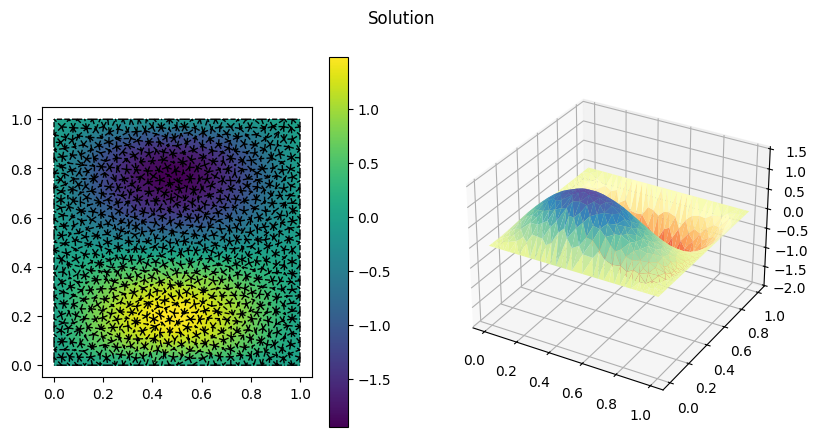

In [14]:
gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)
#gedim.ExportSolution(Burger_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

In [15]:
print("mesh.shape:", mesh.shape)              # Dovrebbe essere (2, N_nodes)
print("u_k.shape:", u_k.shape)
print("u_strong.shape:", u_strong.shape)


mesh.shape: (3, 830)
u_k.shape: (713,)
u_strong.shape: (117,)


### POD START

In [16]:
##### needed for the inner product #####
# MAI USATA

def Domain(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	return values.ctypes.data	

#### Scalar product for the covariance matrix

In [17]:
inner_product = stiffness ######## semi-norm (equivalent)

In [18]:
# tol for the cumulative sum eigenvalue ratio and max number of eigs to take
tol = 1. - 1e-7
N_max = 10
### covariance matrix
C = snapshot_matrix @ inner_product @ np.transpose(snapshot_matrix) 

###### shape?? ############

#### ALTERNATIVE:  VM, L, VMt = np.linalg.svd((C))

L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []

#### check

for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.)
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues)
retained_energy_vector = np.cumsum(eigenvalues)
relative_retained_energy = retained_energy_vector/total_energy
print(relative_retained_energy)


if all(flag==False for flag in relative_retained_energy>= tol):
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1

print("The reduced dimension is", N, '.')


[0.38288861 0.85802484 0.98166001 0.99954871 0.99999146 0.99999593
 0.9999993  0.99999968 0.99999991 0.99999998 0.99999999 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
Th

In [19]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
    eigenvector =  eigenvectors[n]
  
    # basis_component= (1/np.sqrt(snapshot_num))*np.transpose(snapshot_matrix)@eigenvector  (This is the one of the book!!)
  
    basis_component= np.transpose(snapshot_matrix)@eigenvector
    print("basis_component shape:", basis_component.shape)

    norm = np.sqrt(np.transpose(basis_component) @ inner_product @ basis_component) 
    basis_component/= norm
    basis_functions.append(np.copy(basis_component))

basis_functions = np.transpose(np.array(basis_functions))
print("basis shape:", basis_functions.shape)


basis_component shape: (713,)
basis_component shape: (713,)
basis_component shape: (713,)
basis_component shape: (713,)
basis_component shape: (713,)
basis_component shape: (713,)
basis_component shape: (713,)
basis_component shape: (713,)
basis_component shape: (713,)
basis shape: (713, 9)


#### Functions used to assemble the reduced matrices and vectors

In [20]:
def assemble_reduced_matrix(basis, fom_matrix):
    return np.transpose(basis) @ (fom_matrix) @ basis

def assemble_reduced_vector(basis, fom_vector):
    return np.transpose(basis) @ (fom_vector)

#### Define the initial guess and strong vector at the FOM level

In [21]:
# initial guess u (viene rifatta nel for)
u_k = np.zeros(problemData['NumberDOFs'], order='F') # eventualmente modifica: così potrebbe non convergere
# value on the border (=0) bc homogenous dirichlet
u_strong = np.zeros(problemData['NumberDOFs'], order='F')

#### Define the initial guess and strong vector at the ROM level

In [22]:
# our reduced initial guess (viene rifatta nel for)
reduced_u_k = np.zeros(N)
# value on the border (=0) bc homogenous dirichlet
reduced_u_strong = np.zeros(N)

#### Assemble the reduced versions for stiffness matrix and for the vectors for the term f3 and f4 
They are outside the loops so we can do it once and for all at the beginning.

In [23]:
##### STILL OFFLINE
reduced_stiff = assemble_reduced_matrix(basis_functions, stiffness)
reduced_f_3 = assemble_reduced_vector(basis_functions, forcingTerm_f_3)

#### Define a new test set for mu

In [24]:
# Choose new random seed bc we need a new test set
np.random.seed(23)

test_set = np.random.uniform(low=0.1, high=1, size=(100, 2)) # test set

#### Apply Newton to POD
The stopping criterion is based on the relative L2 norm of the projected POD solution at the FOM level.
USE THE TEST SET.

In [25]:
print("{:<8s} {:<6s} {:>14s} {:>10s} {:>10s} {:>15s}".format(
    "DOFs", "h", "Rel. Residual", "Iter", "Max Iter", "mu = (μ₀, μ₁)"
))

# append the projected solution for each mu in test_set
sol_pod = []
# append the sum of total time taken to solve ONLY the linear systems in the while loop, for each mu is it a sum of the total time taken in all ietrations
times_pod = []
# append solution on quadrature points
sol_quad_pod = []
#append solution derivative wrt x on quadraure points
der_x_quad_pod = []
#append solution derivative wrt y on quadraure points
der_y_quad_pod = []

for mu in test_set:
    # devo riaggiornare u_k inizale ogni volta, (ma in realtà ha anche senso dargli la soluzione precednte che è buona per avere una convergenza più rapida)
    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    reduced_u_k = np.zeros(N)
    mu_0 = mu[0]
    mu_1 = mu[1]
    u_normL2 = 1
    u_normH1 = 1
    num_iteration = 1
    residual_norm = 10
    solution_norm = 1.0 # = u_normL2
    # have to compute it here for each mu
    forcingTerm_f_4 = gedim.AssembleForcingTerm(Term_f_4, problemData, lib)
    reduced_f_4 = assemble_reduced_vector(basis_functions, forcingTerm_f_4)
    # INIZIALIZE TO 0 FOR EACH MU
    time_pod = 0
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        # Assemble these FOM level quantities in every iteration of the while loop
        
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction_b, Reaction_non_linear_b, u_k, u_strong, problemData, lib)
        forcingTerm_der_f_1 = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative_f_1, Term_non_linear_der_f_1, u_k, u_strong, problemData, lib)
        forcingTerm_f_2 = gedim.AssembleNonLinearForcingTerm(Ones_f_2, Term_non_linear_f_2, u_k, u_strong, problemData, lib)
        
        # Compute their reduced versions
        reduced_reaction = assemble_reduced_matrix(basis_functions, reaction)
        reduced_f_2 = assemble_reduced_vector(basis_functions, forcingTerm_f_2)
        reduced_der_f_1 = assemble_reduced_vector(basis_functions, forcingTerm_der_f_1)

        # define right and left hand sides fir the ROM level
        reduced_rhs = -reduced_der_f_1 - mu_0/mu_1 * reduced_f_2 + mu_0/mu_1 * reduced_f_3 + reduced_f_4
        reduced_lhs = reduced_stiff + mu_0 * reduced_reaction
        #print("LHS shape:", reduced_lhs.shape)
        #print("RHS shape:", reduced_rhs.shape)

        time_start = time.time()
        # solve linear system to find  reduced du
        reduced_du = np.linalg.solve(reduced_lhs, reduced_rhs)
        time_pod += time.time() - time_start
        # update reduced u_k
        reduced_u_k = reduced_u_k + reduced_du
        
        #project at the FOM LEVEL, we need u_k bc it is used to assemble the nonlinear terms
        du = basis_functions @ reduced_du
        u_k =  basis_functions @ reduced_u_k # quando invece faccio da ROM a FOM è col trasposto : b'vettore
        #print('uk is ', u_k)
        
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        solution_norm =  u_normL2
        residual_norm =  du_normL2
        #print(residual_norm)"""
        """relative L2 e H1 errore non hann senso qui perche riferiti alla soluzione esatta"""
        
        print("{:<8d} {:<8.3f} {:<14.6e} {:<6d} {:<6d}   mu = ({:.3f}, {:.3f})".format(
            problemData['NumberDOFs'],
            problemData['H'],
            residual_norm / u_normL2,
            num_iteration,
            max_iterations,
            mu_0,
            mu_1
        ))

        num_iteration += 1
        
    sol_pod.append(np.copy(u_k))
    times_pod.append(time_pod)
    # save solutions on quadrature points
    [numQuadraturePoints, quadraturePoints, quadratureWeights, solution_pod, solution_x_pod, solution_y_pod] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
    #gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, solution_pod, lib)
    # append solution on qudrature points
    sol_quad_pod.append(solution_pod)
    #append solution derivative wrt x on quadraure points
    der_x_quad_pod.append(solution_x_pod)
    #append solution derivative wrt y on quadraure points
    der_y_quad_pod.append(solution_y_pod)
last_proj_sol = u_k

DOFs     h       Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
713      0.064    1.000000e+00   1      100      mu = (0.566, 0.952)
713      0.064    1.075211e-02   2      100      mu = (0.566, 0.952)
713      0.064    1.261477e-06   3      100      mu = (0.566, 0.952)
713      0.064    4.785187e-13   4      100      mu = (0.566, 0.952)
713      0.064    1.000000e+00   1      100      mu = (0.789, 0.354)
713      0.064    6.417426e-03   2      100      mu = (0.789, 0.354)
713      0.064    2.199549e-07   3      100      mu = (0.789, 0.354)
713      0.064    3.414578e-13   4      100      mu = (0.789, 0.354)
713      0.064    1.000000e+00   1      100      mu = (0.299, 0.718)
713      0.064    2.576940e-02   2      100      mu = (0.299, 0.718)
713      0.064    6.077970e-05   3      100      mu = (0.299, 0.718)
713      0.064    3.400432e-10   4      100      mu = (0.299, 0.718)
713      0.064    1.000000e+00   1      100      mu = (0.250, 0.453)
713      0.064    1.145685e-02   2

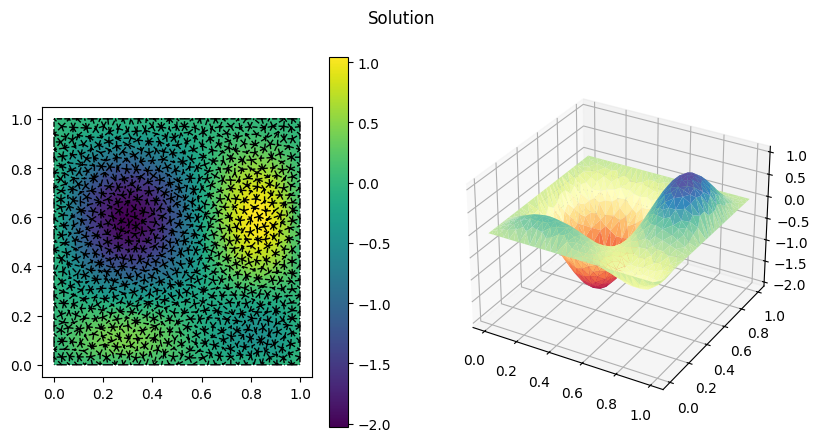

In [26]:
# Plot on the last mu of test_set
gedim.PlotSolution(mesh, dofs, strongs, last_proj_sol, np.zeros(problemData['NumberStrongs']))
#gedim.ExportSolution(Burger_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, solution_pod, solution_x_pod, solution_y_pod] = gedim.EvaluateSolutionOnPoints(last_proj_sol, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, solution_pod, lib)

#### Compute the error of the POD solution wrt the HF solution.
To do so, compute the HF solution for each mu of the test set.

In [27]:
# Troviamo le soluzioni high fidelity 

print("{:<8s} {:<6s} {:>14s} {:>10s} {:>10s} {:>15s}".format(
    "DOFs", "h", "Rel. Residual", "Iter", "Max Iter", "mu = (μ₀, μ₁)"
))
#Possono stare fuori tutti i temini che non dipendono da termini non lienari (uk) e quindi detro il while loro, e quelli che non dipendono da mu
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion_a, problemData, lib)
forcingTerm_f_3 = gedim.AssembleForcingTerm(Ones_f_3, problemData, lib)

# append the solutions
sol_hf = []
# append the sum of total time taken to solve ONLY the linear systems in the while loop, for each mu is it a sum of the total time taken in all ietrations
times_hf = []
# append solution on quadrature points
sol_quad_hf = []
#append solution derivative wrt x on quadraure points
der_x_quad_hf = []
#append solution derivative wrt y on quadraure points
der_y_quad_hf = []

for mu in test_set:
    # devo riaggiornare u_k inizale ogni volta, (ma in realtà ha anche senso dargli la soluzione precednte che è buona per avere una convergenza più rapida)
    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    mu_0 = mu[0]
    mu_1 = mu[1]
    u_normL2 = 1
    u_normH1 = 1
    num_iteration = 1
    residual_norm = 10
    solution_norm = 1.0
    forcingTerm_f_4 = gedim.AssembleForcingTerm(Term_f_4, problemData, lib)

    # INIZIALIZE TO 0 FOR EACH MU   
    time_hf = 0
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction_b, Reaction_non_linear_b, u_k, u_strong, problemData, lib)

        forcingTerm_der_f_1 = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative_f_1, Term_non_linear_der_f_1, u_k, u_strong, problemData, lib)
        forcingTerm_f_2 = gedim.AssembleNonLinearForcingTerm(Ones_f_2, Term_non_linear_f_2, u_k, u_strong, problemData, lib)

        # define right and left hand sides
        rhs = -forcingTerm_der_f_1 - mu_0/mu_1 * forcingTerm_f_2 + mu_0/mu_1 * forcingTerm_f_3 + forcingTerm_f_4
        lhs = stiffness + mu_0 * reaction

        time_start = time.time()
        # solve linear system to find du
        du = gedim.LUSolver(lhs, \
                rhs, \
                lib)
        time_hf += time.time() - time_start
        #update u_k
        u_k = u_k + du
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
    
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        solution_norm =  u_normL2
        residual_norm =  du_normL2
        #print(residual_norm)
        """relative L2 e H1 errore non hann senso qui perche riferiti alla soluzione esatta"""
        
        print("{:<8d} {:<8.3f} {:<14.6e} {:<6d} {:<6d}   mu = ({:.3f}, {:.3f})".format(
            problemData['NumberDOFs'],
            problemData['H'],
            residual_norm / u_normL2,
            num_iteration,
            max_iterations,
            mu_0,
            mu_1
        ))

        num_iteration += 1
    sol_hf.append(np.copy(u_k))
    times_hf.append(time_hf)
    # save solutions on quadrature points
    [numQuadraturePoints, quadraturePoints, quadratureWeights, solution_hf, solution_x_hf, solution_y_hf] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
    # append solution on qudrature points
    sol_quad_hf.append(solution_hf)
    #append solution derivative wrt x on quadraure points
    der_x_quad_hf.append(solution_x_hf)
    #append solution derivative wrt y on quadraure points
    der_y_quad_hf.append(solution_y_hf)
last_sol =u_k

DOFs     h       Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
713      0.064    1.000000e+00   1      100      mu = (0.566, 0.952)
713      0.064    1.073745e-02   2      100      mu = (0.566, 0.952)
713      0.064    1.261623e-06   3      100      mu = (0.566, 0.952)
713      0.064    3.422512e-14   4      100      mu = (0.566, 0.952)
713      0.064    1.000000e+00   1      100      mu = (0.789, 0.354)
713      0.064    6.603278e-03   2      100      mu = (0.789, 0.354)
713      0.064    2.276459e-07   3      100      mu = (0.789, 0.354)
713      0.064    3.862209e-16   4      100      mu = (0.789, 0.354)
713      0.064    1.000000e+00   1      100      mu = (0.299, 0.718)
713      0.064    2.576373e-02   2      100      mu = (0.299, 0.718)
713      0.064    6.083864e-05   3      100      mu = (0.299, 0.718)
713      0.064    3.445196e-10   4      100      mu = (0.299, 0.718)
713      0.064    1.000000e+00   1      100      mu = (0.250, 0.453)
713      0.064    1.145699e-02   2

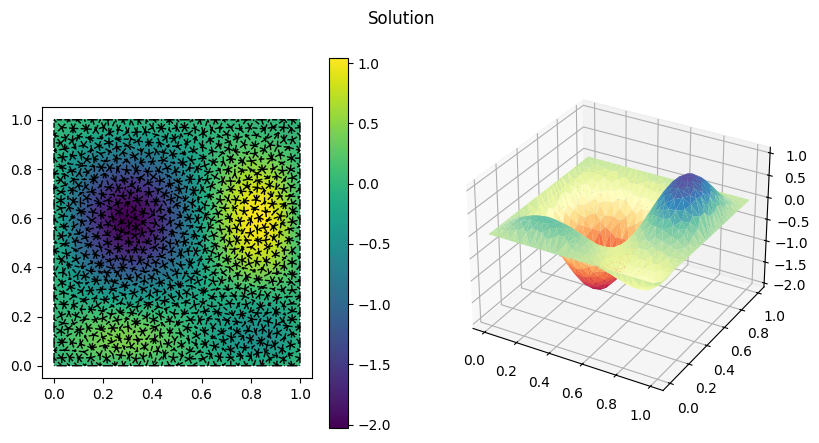

In [28]:
# Plot on the last mu of test_set
gedim.PlotSolution(mesh, dofs, strongs, last_sol, np.zeros(problemData['NumberStrongs']))
#gedim.ExportSolution(Burger_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, solution_hf, solution_x_hf, solution_y_hf] = gedim.EvaluateSolutionOnPoints(last_sol, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, solution_hf, lib)

#### Compute the average errors and speedups.
##### NB: we should also use quadrature points

In [29]:
abs_err=[]
rel_err=[]
speed_up=[]
for i in range(len(sol_hf)): #len(test_set)
    error_function = sol_hf[i] - sol_pod[i]
    error_norm_squared_component = np.transpose(error_function) @ inner_product @ error_function
    absolute_error = np.sqrt(abs(error_norm_squared_component))
    abs_err.append(absolute_error)

    full_solution_norm_squared_component = np.transpose(sol_hf[i]) @ inner_product @ sol_hf[i]
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)

    speed_up.append(times_hf[i]/times_pod[i])

In [30]:
print(f"Average relative error = {np.mean(rel_err):.4e}")
print(f"Average absolute error = {np.mean(abs_err):.4e}")
print("Average speed-up = ", np.mean(speed_up)) # unica cosa variabile perché ho fissato random seed

Average relative error = 8.3333e-04
Average absolute error = 4.9738e-03
Average speed-up =  73.36949771315774


#### Compute mean error on quadrature points

Now, compute the mean squared and absolute errors

In [31]:
def compute_L2_H1_errors_separated(HF_u_set, HF_ux_set, HF_uy_set,
                                   POD_u_set, POD_ux_set, POD_uy_set,
                                   weights=None):
    """
    Compute average L2 and H1 norm errors over a set of HF and POD values
    passed as separate arrays for u, ux, uy.
    Average bc we have all the solutions varying mu in test set.

    Parameters:
    - HF_u_set: list of np.ndarray, each is HF solution u for a given mu
    - HF_ux_set: list of np.ndarray, HF derivative in x
    - HF_uy_set: list of np.ndarray, HF derivative in y
    - POD_u_set: list of np.ndarray, POD solution u
    - POD_ux_set: list of np.ndarray, POD derivative in x
    - POD_uy_set: list of np.ndarray, POD derivative in y
    - weights: np.ndarray or None, quadrature weights (same length as each u)

    Returns:
    - dict with average L2 and H1 norm errors
    """

    l2_errors = []
    h1_errors = []
    l2_rel_errors = []
    h1_rel_errors = []

    for u_HF, ux_HF, uy_HF, u_POD, ux_POD, uy_POD in zip(
        HF_u_set, HF_ux_set, HF_uy_set,
        POD_u_set, POD_ux_set, POD_uy_set):

        # Compute errors
        err_u = u_POD - u_HF
        err_ux = ux_POD - ux_HF
        err_uy = uy_POD - uy_HF

        if weights is not None:
            l2 = np.sqrt(np.sum(weights * err_u**2))
            h1 = np.sqrt(np.sum(weights * (err_u**2 + err_ux**2 + err_uy**2)))
            l2_rel = l2/np.sqrt(np.sum(weights * u_HF**2))
            h1_rel = h1/np.sqrt(np.sum(weights * (u_HF**2 + ux_HF**2 + uy_HF**2)))
        else:
            l2 = np.linalg.norm(err_u)
            h1 = np.sqrt(np.linalg.norm(err_u)**2 +
                         np.linalg.norm(err_ux)**2 +
                         np.linalg.norm(err_uy)**2)

        l2_errors.append(l2)
        h1_errors.append(h1)
        l2_rel_errors.append(l2_rel)
        h1_rel_errors.append(h1_rel)

    avg_l2 = np.mean(l2_errors)
    avg_h1 = np.mean(h1_errors)
    avg_l2_rel = np.mean(l2_rel_errors)
    avg_h1_rel = np.mean(h1_rel_errors)

    print(f"Avg_L2_Norm_Error computed on quadrature points: {avg_l2:.4e}")
    print(f"Avg_H1_Norm_Error computed on quadrature points: {avg_h1:.4e}")
    print('----------------------------------------------------------------')
    print(f"Avg_L2_Norm_Rel_Error computed on quadrature points: {avg_l2_rel:.4e}")
    print(f"Avg_H1_Norm_Rel_Error computed on quadrature points: {avg_h1_rel:.4e}")

    return {
        "Avg_L2_Norm_Error computed on quadrature points": avg_l2,
        "Avg_H1_Norm_Error computed on quadrature points": avg_h1,
        "Avg_L2_Norm_Rel_Error computed on quadrature points": avg_l2_rel,
        "Avg_H1_Norm_Rel_Error computed on quadrature points": avg_h1_rel
    }


In [32]:
errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pod,der_x_quad_pod,der_y_quad_pod, weights=quadratureWeights)

Avg_L2_Norm_Error computed on quadrature points: 4.5728e-04
Avg_H1_Norm_Error computed on quadrature points: 4.9949e-03
----------------------------------------------------------------
Avg_L2_Norm_Rel_Error computed on quadrature points: 5.4025e-04
Avg_H1_Norm_Rel_Error computed on quadrature points: 8.2706e-04


In [33]:
#ERRORI PIU ALTI DELL'1

### POD-NN

In [34]:
"""
import torch
import torch.nn as nn
import torch.nn.functional as F

#num of parameters i need
mu_dim = 2
#dimension of basis, input and output
# i need the dimensions of input and output bc we are building a net
# input is mu which has dim 2 (is in R2), output is u(mu) which has dim N (is in R3) (in our case 3)
basis_dim = N 
input_dim = mu_dim
output_dim = basis_dim
nodes = 30

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # we have 3 hidden layers , 1 layer connecting inputs to hidden layers and  1 layer to output
        self.fc1 = nn.Linear(input_dim, nodes) 
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        self.fc5 = nn.Linear(nodes, output_dim)
        self.tanh = nn.Tanh()
        # self.apply(self._init_weights)


    def forward(self, x):  ### Forward law ----> prediction
        x = self.tanh(self.fc1(x))   
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x) #not used in the end bc tanh is in range[-1,1]. in this case it would work, but usually you do not know
        return x
"""

'\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\n\n#num of parameters i need\nmu_dim = 2\n#dimension of basis, input and output\n# i need the dimensions of input and output bc we are building a net\n# input is mu which has dim 2 (is in R2), output is u(mu) which has dim N (is in R3) (in our case 3)\nbasis_dim = N \ninput_dim = mu_dim\noutput_dim = basis_dim\nnodes = 30\n\nclass Net(nn.Module):\n\n    def __init__(self):\n        super(Net, self).__init__()\n        # we have 3 hidden layers , 1 layer connecting inputs to hidden layers and  1 layer to output\n        self.fc1 = nn.Linear(input_dim, nodes) \n        self.fc2 = nn.Linear(nodes, nodes)\n        self.fc3 = nn.Linear(nodes, nodes)\n        self.fc4 = nn.Linear(nodes, nodes)\n        self.fc5 = nn.Linear(nodes, output_dim)\n        self.tanh = nn.Tanh()\n        # self.apply(self._init_weights)\n\n\n    def forward(self, x):  ### Forward law ----> prediction\n        x = self.tanh(self.fc1(x))   \n    

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#num of parameters i need
mu_dim = 2
#dimension of basis, input and output
# i need the dimensions of input and output bc we are building a net
# input is mu which has dim 2 (is in R2), output is u(mu) which has dim N (is in R3) (in our case 3)
basis_dim = N 
input_dim = mu_dim
output_dim = basis_dim

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # we have 3 hidden layers , 1 layer connecting inputs to hidden layers and  1 layer to output
        self.fc1 = nn.Linear(input_dim, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, output_dim)
        self.tanh = nn.Tanh()
        # self.apply(self._init_weights)


    def forward(self, x):  ### Forward law ----> prediction
        x = self.tanh(self.fc1(x))   
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x)) #not used in the end bc tanh is in range[-1,1]. in this case it would work, but usually you do not know
        x = self.fc5(x)
        return x

In [36]:
seed_num = 23 #if this seed doesn't make training work, change it bc the weights will have another initialization
torch.manual_seed(seed_num)
net = Net()
torch.set_default_dtype(torch.float32)

my_loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epoch_max = 500000
epoch = 0
tol = 1e-5
loss = 1. #initiliaztion of loss

We need to prepare the outputs to train the NN. Indeed, our goal is to define 
$$
\boldsymbol \pi(\boldsymbol \mu) = \underline{u}_{\mathsf{rb}}^{NN}(\boldsymbol \mu).
$$
 Namely, our inputs are the parameters of the training set and the output is the Galerkin projection of the snapshots of the training set.
 The output is of the form $\underline{u}_{\mathsf{rb}}$ where:
 $$
 \mathbb B \underline{u}_{\mathsf{rb}}(\boldsymbol \mu) = \mathbb P^{\boldsymbol \mu}u_{{\delta}}(\boldsymbol \mu), \quad \quad (1)
 $$
 where $\mathbb P^{\boldsymbol \mu} = \mathbb B \mathbb X_{N}^{-1} \mathbb B^T\mathbb X_{N_{\delta}}$ is the reduced vector related to the Galrkin projector, i.e. the best approximation of $u_\delta$ in $V_N$ w.r.t. the inner-product defined by the matrix $X_\delta$. It first projets on the ROM space, but since it is multiplied by B , it is seen with respect to the basis function.

 Instead of computing the inverse of $\mathbb X_{N} = \mathbb B^T \mathbb X_{{\delta}} \mathbb B$ we solve the following system:
 $$
 \mathbb B^T \mathbb X_{{\delta}} \mathbb B \underline{u}_{\mathsf {rb}}(\boldsymbol \mu) =
  \mathbb B^T \mathbb X_{{\delta}} u_{{\delta}}(\boldsymbol \mu)
 $$
 to find $u_{\mathsf{rb}}(\boldsymbol \mu)$ for each snapshot.

In this way we are taking the vector of the reduced solution related to the parameter $\boldsymbol \mu$ **without solving the reduced system**, thanks to the relation (1). This element is the closest element (the best choice) to $u_{\delta}$ in the norm of the problem. Remember you need the FOM solution.

In [37]:
####### training set ########
reduced_inner_product = np.transpose(basis_functions) @ inner_product @ basis_functions
#the parameters
x_train = torch.tensor(np.float32(training_set)) #cioe i mu del training set da cui caloclo gli snapshot e poi gli snapshot proiettati
y_train = []


for i in range(snapshot_matrix.shape[0]):
  
  snapshot_to_project = snapshot_matrix[i]
  # we need to solve X_N*u_rb = B'*X_delta*u_delta
  projected_snapshot = np.linalg.solve(reduced_inner_product, np.transpose(basis_functions)@inner_product@snapshot_to_project)
  
  y_train.append(projected_snapshot) # dim N (3) bc it is projected

y_train = np.float32(y_train)
y_train = torch.tensor(y_train)
print(y_train.shape) #100 rows bc 100 snapshots and 3 bc the reduced space woth has dim 3


torch.Size([100, 9])


In [38]:
while loss >= tol and epoch < epoch_max:
  epoch = epoch + 1
  optimizer.zero_grad()
          
  ## compute output
  output = net(x_train)
  
          
  loss = my_loss(output, y_train)
  if epoch >= 20000:
    optimizer.param_groups[0]['lr'] = 0.0001   #decreasing learning rate after 20000 epochs bc it's usually done after a lot of epochs
  #compute the gradients
  loss.backward()
  # optimizer update
  optimizer.step()
  if epoch % 5000 == 199:
    print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'] )
  #in realtà ho raggiunto 499999 epoche ma qua si ferma prima non so perché            

epoch 199 loss 64.48042297363281 lr 0.001
epoch 5199 loss 0.05509570986032486 lr 0.001
epoch 10199 loss 0.019644087180495262 lr 0.001
epoch 15199 loss 0.0007551953312940896 lr 0.001
epoch 20199 loss 0.0004819552705157548 lr 0.0001
epoch 25199 loss 0.00034833670360967517 lr 0.0001
epoch 30199 loss 0.0002954037918243557 lr 0.0001
epoch 35199 loss 0.00029029458528384566 lr 0.0001
epoch 40199 loss 0.0003004310419782996 lr 0.0001
epoch 45199 loss 0.0001330772356595844 lr 0.0001
epoch 50199 loss 0.00013868941459804773 lr 0.0001
epoch 55199 loss 0.0005396775086410344 lr 0.0001
epoch 60199 loss 7.74850559537299e-05 lr 0.0001
epoch 65199 loss 7.019155600573868e-05 lr 0.0001
epoch 70199 loss 6.377326644724235e-05 lr 0.0001
epoch 75199 loss 5.830472946399823e-05 lr 0.0001
epoch 80199 loss 5.378110654419288e-05 lr 0.0001
epoch 85199 loss 5.010451059206389e-05 lr 0.0001
epoch 90199 loss 4.688666376750916e-05 lr 0.0001
epoch 95199 loss 4.386051659821533e-05 lr 0.0001
epoch 100199 loss 4.127322972635

In [39]:
x_test = [[0.5, .8]]  #sarebbe mu_test
x_test = np.float32(x_test)
x_test = torch.tensor(x_test)

reduced_solution = np.asarray(net(x_test).detach().numpy())[0]

print(reduced_solution)



[-10.37005    -5.239234   20.00012    -5.781385    5.659917   12.154987
   8.11189     2.7084384  -0.7340957]


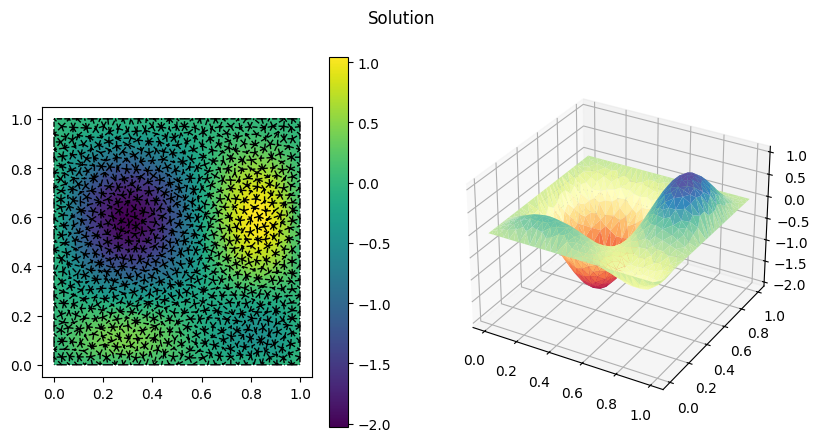

In [40]:
#project it back
nn_proj_reduced_solution = basis_functions @ reduced_solution
gedim.PlotSolution(mesh, dofs, strongs, last_proj_sol, np.zeros(problemData['NumberStrongs']))

In [41]:
### compute error as before, obs here you do not need to assemble teh stifness matrix bc u are not solving any kind of system
import time

print("Computing error and speedup analysis")
abs_err=[]
rel_err=[]
speed_up=[]

sol_quad_podnn = []
der_x_quad_podnn = []
der_y_quad_podnn = []

for i, mu in enumerate(test_set):

    time_fom = times_hf[i]
    #### reduced #####
    
    x_test = [[mu[0], mu[1]]]
    x_test = np.float32(x_test)
    x_test = torch.tensor(x_test)
    
    start_rom = time.time()
    reduced_solution = np.asarray(net(x_test).detach().numpy())[0]
    time_rom = time.time() - start_rom
    
    speed_up.append(time_fom/(time_rom))
    proj_reduced_solution = basis_functions@reduced_solution
    # gedim.PlotSolution(mesh, dofs, strongs, proj_reduced_solution, Dirichlet_top)
    
    
    ### computing error
    
    error_function = sol_hf[i] - proj_reduced_solution
    error_norm_squared_component = np.transpose(error_function) @ inner_product @ error_function
    absolute_error = np.sqrt(abs(error_norm_squared_component))
    abs_err.append(absolute_error)
    
    full_solution_norm_squared_component = np.transpose(sol_hf[i]) @  inner_product @ sol_hf[i]
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)
    #CI VA U_STRONG?????????
    [numQuadraturePoints, quadraturePoints, quadratureWeights, solution_podnn, solution_x_podnn, solution_y_podnn] = gedim.EvaluateSolutionOnPoints(proj_reduced_solution, u_strong, lib)
    #gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, solution_pod, lib)
    # append solution on qudrature points
    sol_quad_podnn.append(solution_podnn)
    #append solution derivative wrt x on quadraure points
    der_x_quad_podnn.append(solution_x_podnn)
    #append solution derivative wrt y on quadraure points
    der_y_quad_podnn.append(solution_y_podnn)



Computing error and speedup analysis


In [42]:
print(f"Average L2 relative error = {np.mean(rel_err):.2e}")
print(f"Average L2 absolute error = {np.mean(abs_err):.2e}")
print(f"Average speed-up = {np.mean(speed_up)}")


Average L2 relative error = 2.18e-02
Average L2 absolute error = 1.43e-01
Average speed-up = 75.29843480738404


#### Errore L2 e H1 sui punti di quadratura

In [43]:
errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_podnn,der_x_quad_podnn,der_y_quad_podnn, weights=quadratureWeights)

Avg_L2_Norm_Error computed on quadrature points: 2.4757e-02
Avg_H1_Norm_Error computed on quadrature points: 1.4487e-01
----------------------------------------------------------------
Avg_L2_Norm_Rel_Error computed on quadrature points: 2.3398e-02
Avg_H1_Norm_Rel_Error computed on quadrature points: 2.1849e-02
